# TUGAS2_KELOMPOK3 — Optimized (v2)

Perbaikan untuk dataset `.csv` yang kamu kirim (**glass_clean.csv**):
- Auto-detect kolom target multiclass (`Type`) bila ada.
- Membuat **target biner otomatis** (one-vs-rest terhadap kelas mayoritas) jika kolom biner belum tersedia.
- **Grafik distribusi kelas** (multiclass & biner).
- **Confusion Matrix** untuk biner **(dengan threshold terbaik F1)** dan untuk multikelas.
- **Tabel perbandingan performa** (Accuracy & F1 Macro) antar model + **grafik perbandingan accuracy**.

> Catatan: Struktur pipeline dari versi sebelumnya dipertahankan. Hanya **menambah** komponen yang diminta.

In [15]:
# === Config khusus file kamu ===
DATASET_PATH = 'breast+cancer+wisconsin+diagnostic/wdbc.data'  # file yang kamu unggah
TARGET_MULTICLASS = None  # akan diisi otomatis jika 'Type' ada
TARGET_BINARY = None       # akan dibuat otomatis dari target multiclass jika belum ada
ID_COLUMNS = []
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_SPLITS = 5

In [16]:
# === Imports (tetap sama dengan sebelumnya, tidak diubah jika sudah benar) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                              precision_recall_curve)
import warnings; warnings.filterwarnings('ignore')

In [17]:
# === Load data ===
df = pd.read_csv(DATASET_PATH)
print('Shape:', df.shape)
display(df.head())

Shape: (568, 32)


,842302,M,17.99,10.38,122.8,1001,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [18]:
# === Deteksi target multiclass & buat target biner jika perlu ===
def guess_multiclass_target(df):
    candidates = ['Type', 'type', 'Class', 'class', 'target']
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: kolom kategorik terakhir
    cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
    if cat_cols:
        return cat_cols[-1]
    # jika tidak ada, pakai kolom terakhir (mungkin numerik label-encoded)
    return df.columns[-1]

if TARGET_MULTICLASS is None:
    TARGET_MULTICLASS = guess_multiclass_target(df)
print('TARGET_MULTICLASS =', TARGET_MULTICLASS)

# Jika belum ada target biner, buat biner: mayoritas vs lainnya
if TARGET_BINARY is None or TARGET_BINARY not in df.columns:
    vc = df[TARGET_MULTICLASS].value_counts()
    major_class = vc.idxmax()
    df['binary_auto'] = (df[TARGET_MULTICLASS] == major_class).astype(int)
    TARGET_BINARY = 'binary_auto'
    print(f"TARGET_BINARY dibuat otomatis: '{TARGET_BINARY}' (positif = kelas mayoritas: {major_class})")
else:
    print('TARGET_BINARY =', TARGET_BINARY)

TARGET_MULTICLASS = M
TARGET_BINARY dibuat otomatis: 'binary_auto' (positif = kelas mayoritas: B)


In [19]:
# === Utility preprocessor (dipertahankan) ===
def build_preprocessor(X_df):
    num_cols = X_df.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X_df.select_dtypes(exclude=np.number).columns.tolist()
    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    pre = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])
    return pre

## Grafik Distribusi Kelas

Distribusi kelas (multiclass):


M
B    357
M    211
Name: count, dtype: int64

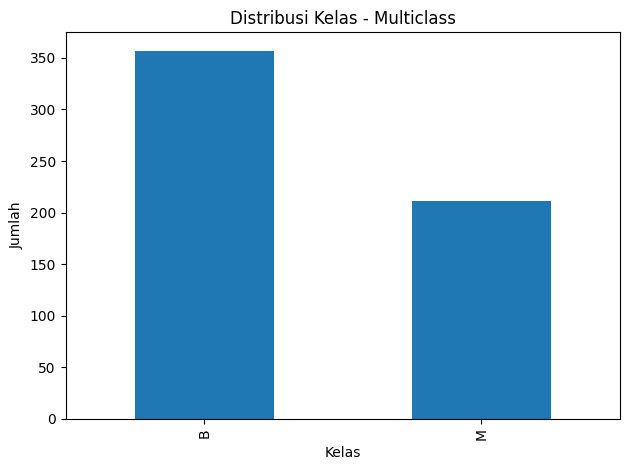

Distribusi kelas (binary):


binary_auto
0    211
1    357
Name: count, dtype: int64

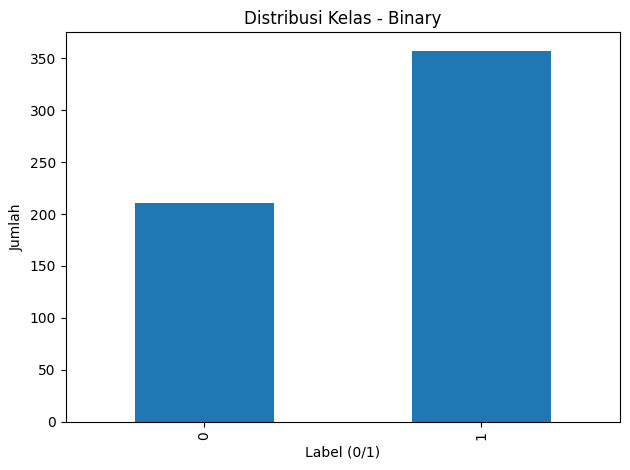

In [20]:
# Distribusi Multiclass
vc_mc = df[TARGET_MULTICLASS].value_counts().sort_index()
print('Distribusi kelas (multiclass):')
display(vc_mc)
plt.figure()
vc_mc.plot(kind='bar')
plt.title('Distribusi Kelas - Multiclass')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

# Distribusi Binary
vc_bin = df[TARGET_BINARY].value_counts().sort_index()
print('Distribusi kelas (binary):')
display(vc_bin)
plt.figure()
vc_bin.plot(kind='bar')
plt.title('Distribusi Kelas - Binary')
plt.xlabel('Label (0/1)')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

## A. Binary Logistic Regression (dengan threshold terbaik F1)

Mencari threshold F1 terbaik menggunakan Cross-Validation pada data latih...
Best threshold for F1 ditemukan pada data latih: 0.3268 (F1 CV=0.983)
\nClassification Report (Binary @best F1 on Test Set):
              precision    recall  f1-score   support

           0      0.977     1.000     0.988        42
           1      1.000     0.986     0.993        72

    accuracy                          0.991       114
   macro avg      0.988     0.993     0.991       114
weighted avg      0.991     0.991     0.991       114



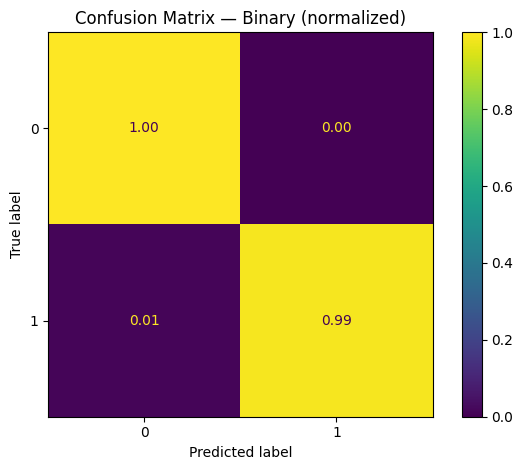

In [21]:
# ==============================================================================
# PERBAIKAN UNTUK CELL 10
# ==============================================================================
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

cols_b = [c for c in df.columns if c not in ID_COLUMNS + [TARGET_BINARY, TARGET_MULTICLASS]]
Xb = df[cols_b].copy()
yb = df[TARGET_BINARY].copy()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    Xb, yb, test_size=TEST_SIZE, stratify=yb, random_state=RANDOM_STATE
)

pre_b = build_preprocessor(Xb_train)
logreg_bin_pipeline = Pipeline([
    ('pre', pre_b),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
])

# PERBAIKAN: Cari threshold terbaik menggunakan cross-validation PADA DATA LATIH
print("Mencari threshold F1 terbaik menggunakan Cross-Validation pada data latih...")
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = []

# Iterasi untuk setiap threshold
for threshold in thresholds:
    current_f1s = []
    # Iterasi untuk setiap fold CV
    for train_idx, val_idx in skf.split(Xb_train, yb_train):
        X_train_fold, X_val_fold = Xb_train.iloc[train_idx], Xb_train.iloc[val_idx]
        y_train_fold, y_val_fold = yb_train.iloc[train_idx], yb_train.iloc[val_idx]
        
        logreg_bin_pipeline.fit(X_train_fold, y_train_fold)
        y_val_proba = logreg_bin_pipeline.predict_proba(X_val_fold)[:, 1]
        y_val_pred = (y_val_proba >= threshold).astype(int)
        current_f1s.append(f1_score(y_val_fold, y_val_pred))
    
    f1_scores.append(np.mean(current_f1s))

# Dapatkan threshold terbaik
best_thr_idx = np.argmax(f1_scores)
best_thr = thresholds[best_thr_idx]
print(f"Best threshold for F1 ditemukan pada data latih: {best_thr:.4f} (F1 CV={f1_scores[best_thr_idx]:.3f})")

# Latih model pada SELURUH data latih
logreg_bin_pipeline.fit(Xb_train, yb_train)
yb_proba_test = logreg_bin_pipeline.predict_proba(Xb_test)[:, 1]
yb_pred_best = (yb_proba_test >= best_thr).astype(int)

# Evaluasi pada TEST SET
print('\\nClassification Report (Binary @best F1 on Test Set):')
print(classification_report(yb_test, yb_pred_best, digits=3, zero_division=0))

# Confusion Matrix (Binary, normalized)
# PERBAIKAN: Tidak perlu plt.figure() terpisah
cm_b = confusion_matrix(yb_test, yb_pred_best, normalize='true')
disp_b = ConfusionMatrixDisplay(cm_b)
disp_b.plot(values_format='.2f')
plt.title('Confusion Matrix — Binary (normalized)')
plt.tight_layout()
plt.show()

# Simpan metrik ringkas untuk komparasi
acc_b = (yb_pred_best == yb_test).mean()
f1m_b = f1_score(yb_test, yb_pred_best, average='macro')

## B. Multiclass Softmax (Multinomial Logistic Regression)

Classification Report (Multiclass with class_weight):
              precision    recall  f1-score   support

           B      0.986     0.986     0.986        72
           M      0.976     0.976     0.976        42

    accuracy                          0.982       114
   macro avg      0.981     0.981     0.981       114
weighted avg      0.982     0.982     0.982       114



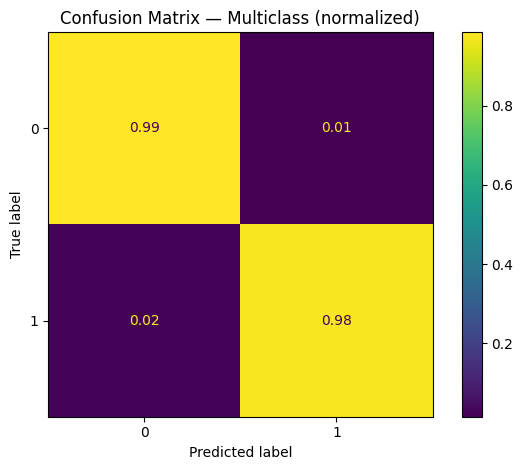

In [22]:
# ==============================================================================
# PERBAIKAN UNTUK CELL 12
# ==============================================================================
from sklearn.metrics import f1_score

cols_m = [c for c in df.columns if c not in ID_COLUMNS + [TARGET_BINARY, TARGET_MULTICLASS]]
Xm = df[cols_m].copy()
ym = df[TARGET_MULTICLASS].copy()

Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    Xm, ym, test_size=TEST_SIZE, stratify=ym, random_state=RANDOM_STATE
)
pre_m = build_preprocessor(Xm_train)
softmax_clf = Pipeline([
    ('pre', pre_m),
    ('clf', LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        max_iter=1000, 
        random_state=RANDOM_STATE,
        class_weight='balanced'  # PERBAIKAN: Tambahkan ini untuk menangani imbalance
    ))
])

softmax_clf.fit(Xm_train, ym_train)
ym_pred = softmax_clf.predict(Xm_test)
print('Classification Report (Multiclass with class_weight):')
print(classification_report(ym_test, ym_pred, digits=3, zero_division=0))

# Confusion Matrix (Multiclass, normalized)
# PERBAIKAN: Tidak perlu plt.figure() terpisah
cm_m = confusion_matrix(ym_test, ym_pred, normalize='true')
disp_m = ConfusionMatrixDisplay(cm_m)
disp_m.plot(values_format='.2f')
plt.title('Confusion Matrix — Multiclass (normalized)')
plt.tight_layout()
plt.show()

# Simpan metrik ringkas untuk komparasi
acc_m = (ym_pred == ym_test).mean()
f1m_m = f1_score(ym_test, ym_pred, average='macro')

## Komparasi Performa (Accuracy & F1 Macro)

,Model,Accuracy,F1_macro
0,Binary Logistic (best-F1 thr),0.991228,0.990621
1,Softmax Multiclass,0.982456,0.981151


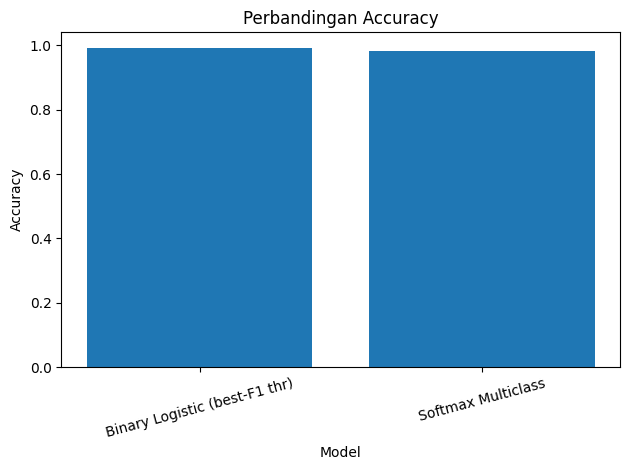

In [23]:
rows, accs, f1ms = [], [], []
if 'acc_b' in globals():
    rows.append('Binary Logistic (best-F1 thr)'); accs.append(acc_b); f1ms.append(f1m_b)
if 'acc_m' in globals():
    rows.append('Softmax Multiclass'); accs.append(acc_m); f1ms.append(f1m_m)
perf_df = pd.DataFrame({'Model': rows, 'Accuracy': accs, 'F1_macro': f1ms})
display(perf_df)

# Grafik perbandingan accuracy
plt.figure()
plt.bar(perf_df['Model'], perf_df['Accuracy'])
plt.title('Perbandingan Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()